In [241]:
import numpy as np
arr = np.array
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import cv2
from scipy.signal import savgol_filter

Экспериемент первый

Воспользумся формулой $N = \cfrac{2\Delta x}{\lambda} \implies \lambda = \cfrac{2\Delta x}{N}$, усредним по результат по всем измерениям и получим:

In [242]:
N = arr([10, 20, 30, 40, 50, 60])
x = arr([3.5, 6, 9.2, 12, 15, 18.5])

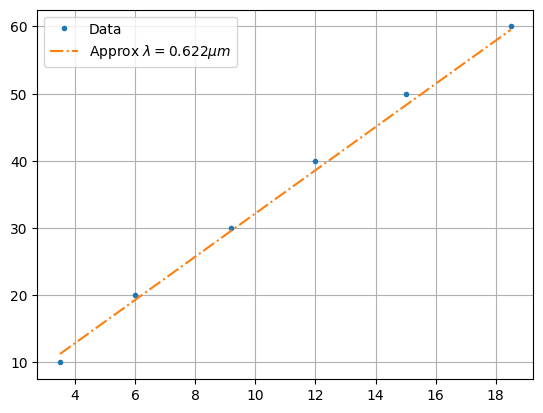

In [243]:
l = np.mean(2*x/N)
f = lambda x: 2*x/l
plt.plot(x, N, '.', label = "Data")
plt.plot(x, f(x), '-.', label = "Approx $\lambda =" + str(np.around(l*1000, 0)) +"\\mu m$"  )
plt.grid(True)
plt.legend()
plt.savefig("Ex_1/approx.png")

Для нахождения длинны когерентности:

$$
L_c = \cfrac{\lambda^2}{\Delta \lambda} = 2.8mm
$$

На практике мне не удплось найти длинну когерентности так как, она очень велика. 


Здесь находим производные велечины

In [244]:
l = l * 10**(-6)
c = 299792458
omega = 2*np.pi*c/l

Эксперемент второй

Длинна пути в стекле будет поределяться по формуле:
$$
l = \cfrac{d}{\cos{\varphi + \varphi_0}}
$$
Где $\varphi -$угогол поворота пластины. Скороть в среде:
$$
v = \cfrac{c}{n}
$$
В итоге получим:
$$
\psi = 4\cfrac{dn}{\cos{\varphi + \varphi_0} \lambda}\pi
$$
а разность фаз:
$$
\psi = 4\left(\cfrac{dn}{\cos{\varphi_0} \lambda} - \cfrac{dn}{\cos{\varphi + \varphi_0} \lambda}\right)\pi
$$
Тогда количество смен max-min:
$$
N = 2\left(\cfrac{dn}{\cos{\varphi_0} \lambda} - \cfrac{dn}{\cos{\varphi + \varphi_0} \lambda}\right)
$$

In [245]:
phi =  arr([9, 17, 24, 29, 36, 42, 48, 53])/(180*60)*np.pi 
N = arr([3, 6, 9, 12, 15, 18, 21, 24])

In [246]:
f = lambda x, d, n, l, a: 2*(-d*n/np.cos(a/(180*60)*np.pi)+d*n/np.cos(x+a/(180*60)*np.pi))/l

n = 1.6125358819467162
d = 0.012
a = 60


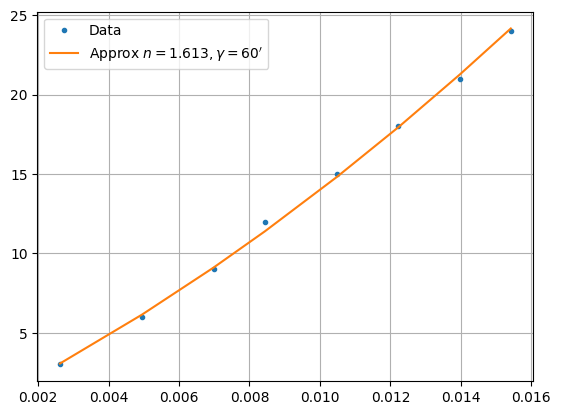

In [247]:
x = phi
y = N
d = 0.012
a = 60
[n], res1 = curve_fit(lambda phi, n: f(phi, d, n, l, a),  x,  y)

y1 = f(x, d, n, l, a)
print(f"n = {n}")
print(f"d = {d}")
print(f"a = {a}")
plt.plot(x, y, '.', label = "Data")

plt.plot(x, y1, label = f"Approx $n = {n:0.3f}, \gamma = {a}'$")
plt.grid(True)
plt.legend()
plt.savefig("Ex_2/wight.png")
plt.show()

In [248]:
phi =  arr([5, 8.5, 14, 19, 22, 26.5, 30.5, 34])/(180*60)*np.pi 
N = arr([3, 6, 9, 12, 15, 18, 21, 24])

n = 2.2999999999999994
d = 0.0075
a = 131.65209140160525


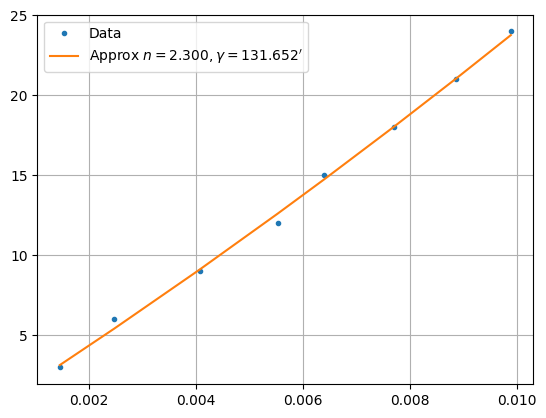

In [249]:
x = phi
y = N
d = 0.0075
[n, a], res1 = curve_fit(lambda phi, n, a: f(phi, d, n, l, a),  x,  y, bounds = ([1.4, 0], [2.3, 300]))

y1 = f(x, d, n, l, a)
print(f"n = {n}")
print(f"d = {d}")
print(f"a = {a}")
plt.plot(x, y, '.', label = "Data")

plt.plot(x, y1, label = f"Approx $n = {n:0.3f}, \gamma = {a:0.3f}'$")
plt.grid(True)
plt.legend()
plt.savefig("Ex_2/thin.png")
plt.show()

Эксперимент третий

Оработка данных находи мколичесво смен max-min

In [250]:
def count_brightness_changes(video_path, center, radius):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Read the first frame
    ret, prev_frame = video.read()
    if not ret:
        raise ValueError("Error reading video file")

    # Convert the frame to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    plt.figure(1)
    plt.imshow(prev_gray, cmap='gray')
    plt.plot(*center, '.')
    ax = plt.gca()
    circle2 = plt.Circle(center, radius, color='b', fill=False)
    ax.add_patch(circle2)

    
    # Create a circular mask for the ROI
    mask = np.zeros(prev_gray.shape, dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)

    masked_frame = cv2.bitwise_and(prev_gray, mask)
    last_mean = cv2.mean(masked_frame)[0]

    # Initialize variables
    transitions = 0
    prev_zone = None
    arr = [last_mean]
    while True:
        # Read the next frame
        ret, curr_frame = video.read()
        if not ret:
            break

        # Convert the frame to grayscale
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        # Apply the circular mask to the frame
        masked_frame = cv2.bitwise_and(curr_gray, mask)

        curr_mean = cv2.mean(masked_frame)[0]
        arr.append(curr_mean)
        # Determine the current zone (dark or bright)

    # Release the video object
    video.release()
    return arr

In [251]:
# Provide the path to your video file
video_file_path = "/home/mat/Downloads/Telegram Desktop/video_2023-05-20_16-15-33.mp4"

# Define the center and radius of the circular ROI
center = (745, 290)
radius = 30

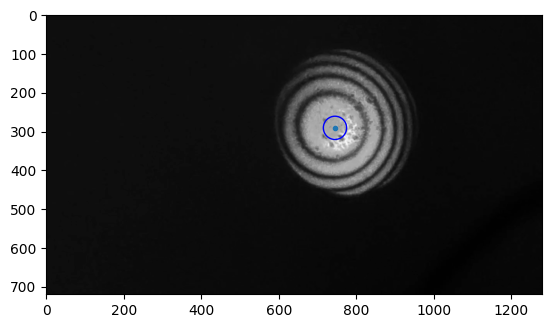

In [252]:
transitions = arr( count_brightness_changes(video_file_path, center, radius))[140:]


202


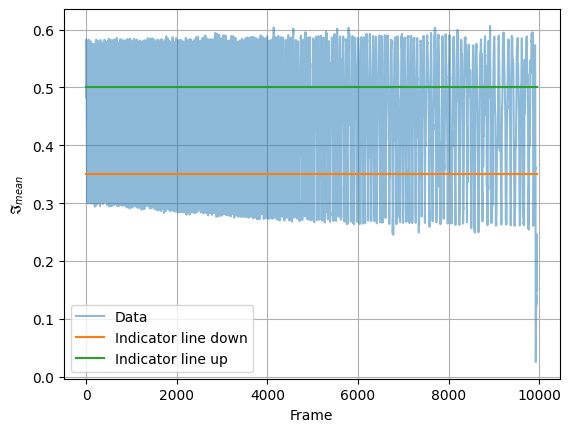

In [253]:
plt.figure(2)
plt.plot(transitions, alpha = 0.5, label = "Data")
plt.grid(True)
plt.plot([0, len(transitions)], [0.35, 0.35], label = "Indicator line down")
plt.plot([0, len(transitions)], [0.5, 0.5], label = "Indicator line up")
plt.xlabel("Frame")
plt.ylabel("$\mathfrak{I}_{mean}$")
plt.legend()
plt.savefig("Ex_3/3_1.png")


n = 0
cr = False
for _ in transitions:
    if (_ > 0.55) & (not cr):
        n += 1
        cr = True
    if (_ < 0.35) & cr:
        cr = False
print(n)
n3 = n

In [254]:
# Provide the path to your video file
video_file_path = "/home/mat/Downloads/Telegram Desktop/video_2023-05-20_16-41-30.mp4"

# Define the center and radius of the circular ROI
center = (725, 290)
radius = 30

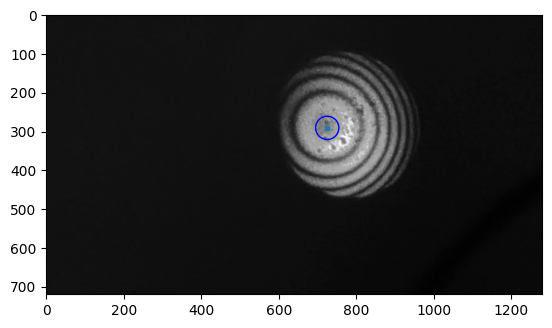

In [255]:
transitions = arr( count_brightness_changes(video_file_path, center, radius))[140:]


235


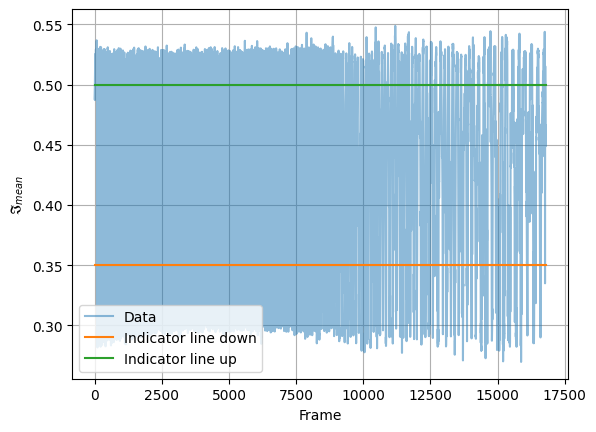

In [256]:

# Call the function to count brightness transitions
plt.figure(2)
plt.plot(transitions, alpha = 0.5, label = "Data")
plt.grid(True)
plt.plot([0, len(transitions)], [0.35, 0.35], label = "Indicator line down")
plt.plot([0, len(transitions)], [0.5, 0.5], label = "Indicator line up")
plt.xlabel("Frame")
plt.ylabel("$\mathfrak{I}_{mean}$")
plt.legend()
plt.savefig("Ex_3/3_2.png")


n = 0
cr = False
for _ in transitions:
    if (_ > 0.5) & (not cr):
        n += 1
        cr = True
    if (_ < 0.35) & cr:
        cr = False
n2 = n
print(n)

In [257]:
# Provide the path to your video file
video_file_path = "/home/mat/Downloads/Telegram Desktop/video_2023-05-20_16-54-54.mp4"

# Define the center and radius of the circular ROI
center = (725, 290)
radius = 30

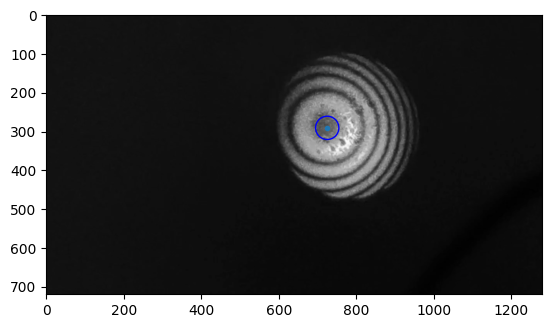

In [258]:
transitions = arr( count_brightness_changes(video_file_path, center, radius))

60


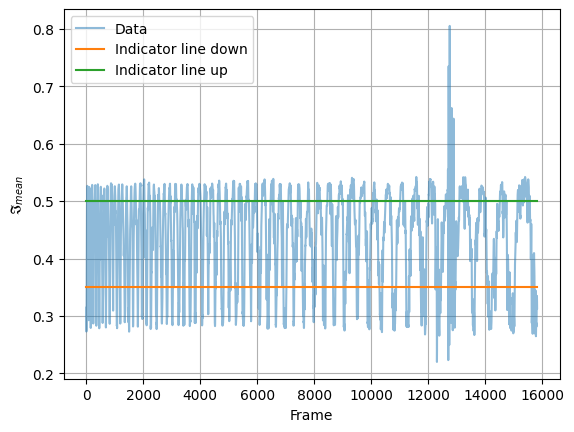

In [259]:

# Call the function to count brightness transitions
transitions = savgol_filter(transitions, window_length = 20, polyorder = 2)


plt.figure(2)
plt.plot(transitions, alpha = 0.5, label = "Data")
plt.grid(True)
plt.plot([0, len(transitions)], [0.35, 0.35], label = "Indicator line down")
plt.plot([0, len(transitions)], [0.5, 0.5], label = "Indicator line up")
plt.xlabel("Frame")
plt.ylabel("$\mathfrak{I}_{mean}$")
plt.legend()
plt.savefig("Ex_3/3_3.png")



n = 0
cr = False
for _ in transitions:
    if (_ > 0.5) & (not cr):
        n += 1
        cr = True
    if (_ < 0.35) & cr:
        cr = False
n1 = n
print(n)


Тперь по формуле из 1 эксперимента найдем $\Delta l$

In [261]:
N = arr([n1, n2, n3])
dl = np.mean(l*N/2)


Предположим что 
$$\Delta l = k \Delta T$$

In [264]:
dT = arr([35-28, 63-35, 88-63])
k = np.mean(dl/dT)
print(f"k = {k/1000}")

k = 3.751758333333334e-09


Эксперимент четвертый

Из спецификации к лазеру от куда получи что:

$$
L_c = \cfrac{\lambda^2}{\Delta \lambda} = \cfrac{635 \mu m^2}{10\mu m} \approx 40 \mu m
$$

Из эксперимента получим что 
$$
L_c = 25 \mu m
$$